## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

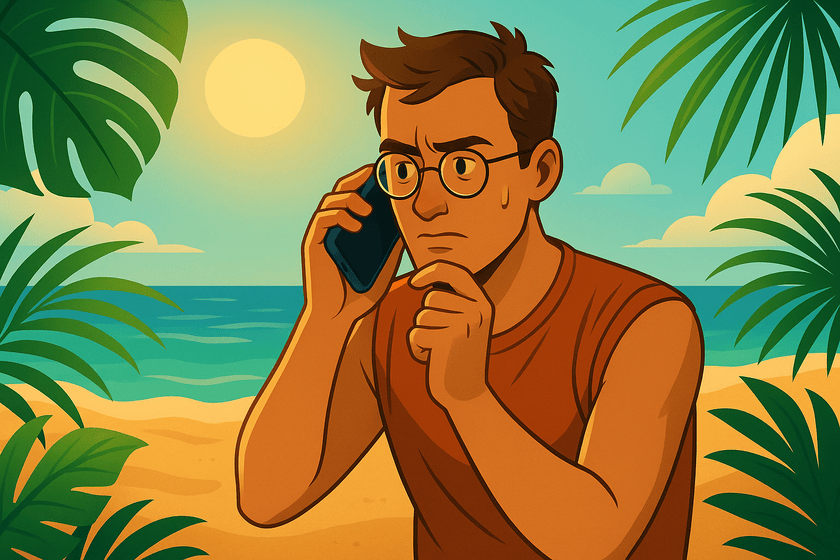

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

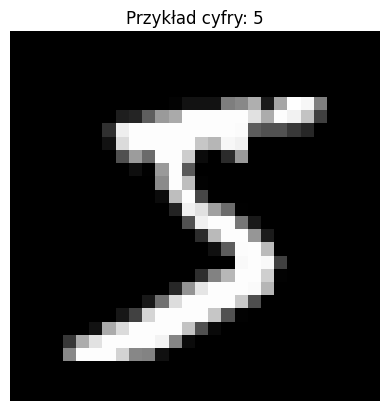

In [ ]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

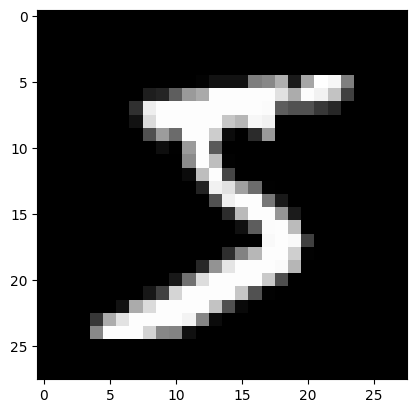

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [ ]:
plt.imshow(x_train[0], cmap='gray')
plt.show()
print(x_train[0])

# **Wstępna konfiguracja i importy**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Przygotowanie danych**

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.75MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.80MB/s]


# **Implementacja i trening modelu Baseline (MLP)**

In [16]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super(BaselineMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_baseline = BaselineMLP().to(device)
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=1e-3)
criterion_baseline = nn.CrossEntropyLoss()
EPOCHS = 10

# Pętla treningowa
for epoch in range(EPOCHS):
    model_baseline.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_baseline.zero_grad()
        outputs = model_baseline(images)
        loss = criterion_baseline(outputs, labels)
        loss.backward()
        optimizer_baseline.step()
    print(f"Epoch {epoch+1}/{EPOCHS} | Baseline MLP Training Complete")

# Ewaluacja na zbiorze testowym
model_baseline.eval()
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_baseline(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

test_acc_baseline = test_correct / len(test_loader.dataset)
print(f"Dokładność modelu Baseline (MLP) na zbiorze testowym: {test_acc_baseline:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10 | Baseline MLP Training Complete
Epoch 2/10 | Baseline MLP Training Complete
Epoch 3/10 | Baseline MLP Training Complete
Epoch 4/10 | Baseline MLP Training Complete
Epoch 5/10 | Baseline MLP Training Complete
Epoch 6/10 | Baseline MLP Training Complete
Epoch 7/10 | Baseline MLP Training Complete
Epoch 8/10 | Baseline MLP Training Complete
Epoch 9/10 | Baseline MLP Training Complete
Epoch 10/10 | Baseline MLP Training Complete
Dokładność modelu Baseline (MLP) na zbiorze testowym: 0.9792


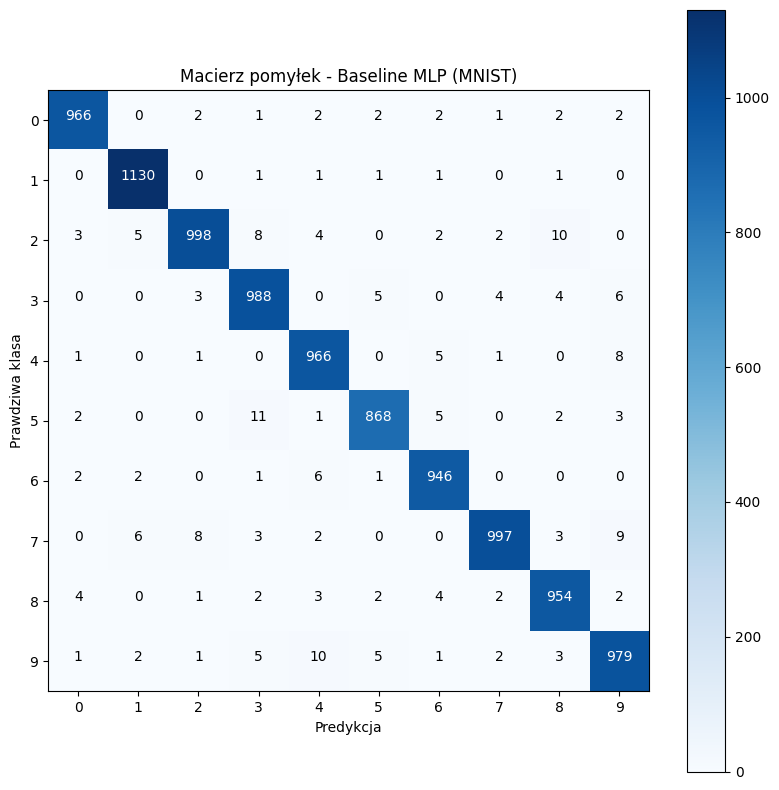

Raport klasyfikacji dla Baseline MLP:
              precision    recall  f1-score   support

           0     0.9867    0.9857    0.9862       980
           1     0.9869    0.9956    0.9912      1135
           2     0.9842    0.9671    0.9756      1032
           3     0.9686    0.9782    0.9734      1010
           4     0.9709    0.9837    0.9772       982
           5     0.9819    0.9731    0.9775       892
           6     0.9793    0.9875    0.9834       958
           7     0.9881    0.9698    0.9789      1028
           8     0.9745    0.9795    0.9770       974
           9     0.9703    0.9703    0.9703      1009

    accuracy                         0.9792     10000
   macro avg     0.9791    0.9790    0.9791     10000
weighted avg     0.9792    0.9792    0.9792     10000



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Przełącz model w tryb ewaluacji
model_baseline.eval()

# Zbieranie predykcji i prawdziwych etykiet ze zbioru testowego
y_true_baseline = []
y_pred_baseline = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_baseline(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true_baseline.extend(labels.cpu().numpy())
        y_pred_baseline.extend(predicted.cpu().numpy())

# Macierz pomyłek
cm_baseline = confusion_matrix(y_true_baseline, y_pred_baseline)
class_names = [str(i) for i in range(10)]

plt.figure(figsize=(8, 8))
plt.imshow(cm_baseline, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Macierz pomyłek - Baseline MLP (MNIST)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

thresh = cm_baseline.max() / 2.
for i, j in itertools.product(range(cm_baseline.shape[0]), range(cm_baseline.shape[1])):
    plt.text(j, i, cm_baseline[i, j],
             horizontalalignment="center",
             color="white" if cm_baseline[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.show()

# Raport klasyfikacji
print("Raport klasyfikacji dla Baseline MLP:")
print(classification_report(y_true_baseline, y_pred_baseline, target_names=class_names, digits=4))

# **Budowa i trening modelu CNN**

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model_cnn = SimpleCNN().to(device)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
criterion_cnn = nn.CrossEntropyLoss()

# Pętla treningowa
for epoch in range(EPOCHS):
    model_cnn.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = model_cnn(images)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
    print(f"Epoch {epoch+1}/{EPOCHS} | SimpleCNN Training Complete")

# Ewaluacja na zbiorze testowym
model_cnn.eval()
test_correct_cnn = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct_cnn += (predicted == labels).sum().item()

test_acc_cnn = test_correct_cnn / len(test_loader.dataset)
print(f"Dokładność modelu SimpleCNN na zbiorze testowym: {test_acc_cnn:.4f}")

Epoch 1/10 | SimpleCNN Training Complete
Epoch 2/10 | SimpleCNN Training Complete
Epoch 3/10 | SimpleCNN Training Complete
Epoch 4/10 | SimpleCNN Training Complete
Epoch 5/10 | SimpleCNN Training Complete
Epoch 6/10 | SimpleCNN Training Complete
Epoch 7/10 | SimpleCNN Training Complete
Epoch 8/10 | SimpleCNN Training Complete
Epoch 9/10 | SimpleCNN Training Complete
Epoch 10/10 | SimpleCNN Training Complete
Dokładność modelu SimpleCNN na zbiorze testowym: 0.9911


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoka 1/10 - Trening: Loss 0.5051, Acc 0.8407 | Walidacja: Loss 0.1100, Acc 0.9664
Epoka 2/10 - Trening: Loss 0.1874, Acc 0.9434 | Walidacja: Loss 0.0779, Acc 0.9754
Epoka 3/10 - Trening: Loss 0.1495, Acc 0.9557 | Walidacja: Loss 0.0617, Acc 0.9832
Epoka 4/10 - Trening: Loss 0.1238, Acc 0.9629 | Walidacja: Loss 0.0552, Acc 0.9846
Epoka 5/10 - Trening: Loss 0.1120, Acc 0.9660 | Walidacja: Loss 0.0492, Acc 0.9858
Epoka 6/10 - Trening: Loss 0.1015, Acc 0.9693 | Walidacja: Loss 0.0463, Acc 0.9860
Epoka 7/10 - Trening: Loss 0.0917, Acc 0.9723 | Walidacja: Loss 0.0465, Acc 0.9864
Epoka 8/10 - Trening: Loss 0.0853, Acc 0.9738 | Walidacja: Loss 0.0475, Acc 0.9868
Epoka 9/10 - Trening: Loss 0.0814, Acc 0.9757 | Walidacja: Loss 0.0437, Acc 0.9888
Epoka 10/10 - Trening: Loss 0.0771, Acc 0.9755 | Walidacja: Loss 0.0412, Acc 0.9882


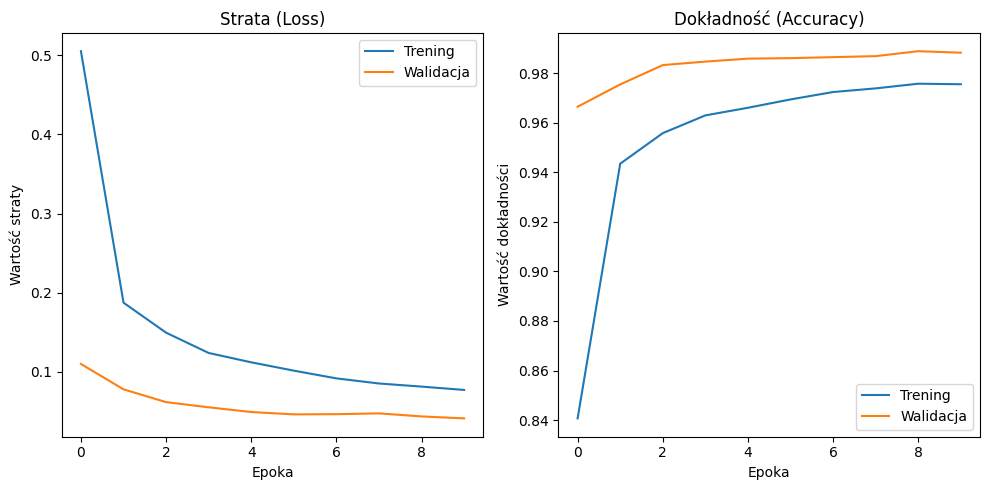

In [21]:
# Modyfikacja pętli treningowej
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        # Trening
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        # Walidacja
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        history["train_loss"].append(train_loss / train_total)
        history["train_acc"].append(train_correct / train_total)
        history["val_loss"].append(val_loss / val_total)
        history["val_acc"].append(val_correct / val_total)
        print(f"Epoka {epoch+1}/{epochs} - Trening: Loss {history['train_loss'][-1]:.4f}, Acc {history['train_acc'][-1]:.4f} | Walidacja: Loss {history['val_loss'][-1]:.4f}, Acc {history['val_acc'][-1]:.4f}")

    return history

# Trening i zbieranie historii dla modelu CNN
model_cnn_new = SimpleCNN().to(device)
optimizer_cnn_new = torch.optim.Adam(model_cnn_new.parameters(), lr=1e-3)
history_cnn = train_and_validate(model_cnn_new, train_loader, val_loader, optimizer_cnn_new, criterion_cnn, EPOCHS)

# Wykresy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn['train_loss'], label='Trening')
plt.plot(history_cnn['val_loss'], label='Walidacja')
plt.title('Strata (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Wartość straty')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn['train_acc'], label='Trening')
plt.plot(history_cnn['val_acc'], label='Walidacja')
plt.title('Dokładność (Accuracy)')
plt.xlabel('Epoka')
plt.ylabel('Wartość dokładności')
plt.legend()

plt.tight_layout()
plt.show()

 Pętla uczenia i walidacji


--- Porównanie wyników ---
Dokładność Baseline MLP: 0.9792
Dokładność SimpleCNN: 0.9911


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


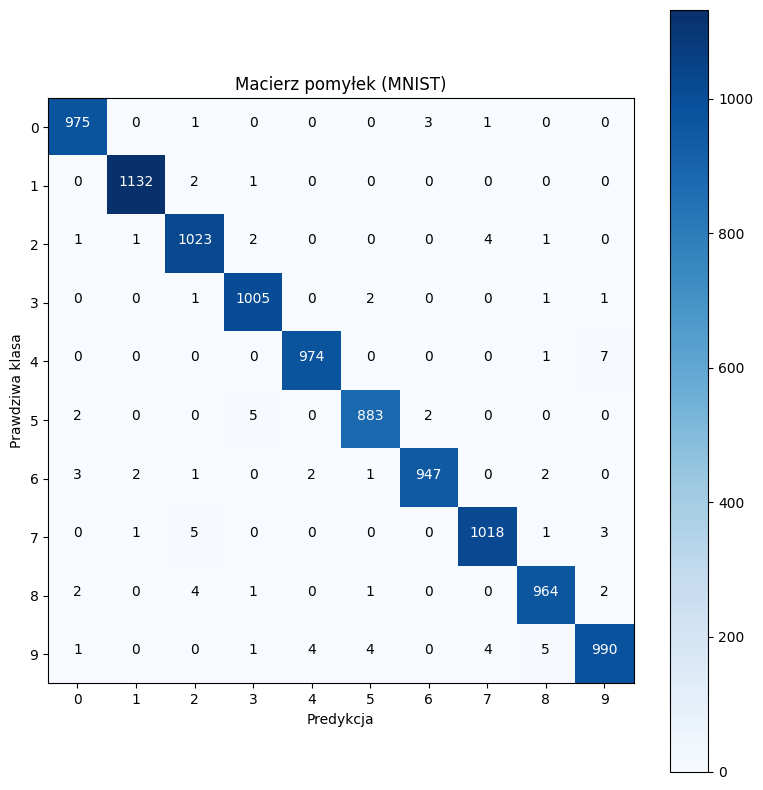


Raport klasyfikacji dla SimpleCNN:
              precision    recall  f1-score   support

           0     0.9909    0.9949    0.9929       980
           1     0.9965    0.9974    0.9969      1135
           2     0.9865    0.9913    0.9889      1032
           3     0.9901    0.9950    0.9926      1010
           4     0.9939    0.9919    0.9929       982
           5     0.9910    0.9899    0.9905       892
           6     0.9947    0.9885    0.9916       958
           7     0.9912    0.9903    0.9908      1028
           8     0.9887    0.9897    0.9892       974
           9     0.9870    0.9812    0.9841      1009

    accuracy                         0.9911     10000
   macro avg     0.9911    0.9910    0.9910     10000
weighted avg     0.9911    0.9911    0.9911     10000



In [19]:
# Porównanie wyników
print("\n--- Porównanie wyników ---")
print(f"Dokładność Baseline MLP: {test_acc_baseline:.4f}")
print(f"Dokładność SimpleCNN: {test_acc_cnn:.4f}")

# Wizualizacja dla modelu CNN
model_cnn.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model_cnn(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Macierz pomyłek (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print("\nRaport klasyfikacji dla SimpleCNN:")
print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)], digits=4))